# Coronavirus in Mexico

April 9th, 2020

https://www.frontiersin.org/articles/10.3389/fphy.2020.00127/full?utm_source=em&utm_medium=f-nlt&utm_campaign=ba_cov_sci_fphy#h6


#Code
http://www.matjazperc.com/COVID-19/

# Data https://ourworldindata.org/coronavirus#the-current-case-fatality-rate-of-covid-19

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cufflinks as cf
import plotly
import os
import math
import sympy as sy
from scipy import integrate
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, median_absolute_error
from scipy.integrate import odeint
from scipy.optimize import differential_evolution, minimize
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from scipy.integrate import odeint
print(__version__) # requires version >= 1.9.0

4.5.2


In [2]:
path = 'figsCovid19'
if not os.path.isdir(path): os.makedirs(path)

In [3]:
# Saving figures
def save_fig(fig,figname):
    fig.savefig(os.path.join(path,figname+'.pdf'),format='pdf')

In [4]:
# Complete Database
myPath='/home/milena/Downloads/2020/ML2020/Data/covid19/'
#data=pd.read_csv('/home/milena/Downloads/2020/ML2020/Data/CoV2019.csv')
data=pd.read_csv(myPath+'data.txt',header=None)
data_who=pd.read_excel(myPath+'COVID-19-geographic-disbtribution-worldwide.xlsx')
data_ger=pd.read_csv(myPath+'germany.txt',header=None)
data_iran=pd.read_csv(myPath+'iran.txt',header=None)
data_slov=pd.read_csv(myPath+'slovenia.txt',header=None)
data_usa=pd.read_csv(myPath+'usa.txt',header=None)
cdmx=pd.read_csv(myPath+'cdmx08042020_500HRS.csv')


In [5]:
len(cdmx)

43

In [6]:
cdmx.set_index('time',inplace=True)

In [7]:
data_who.columns

Index(['dateRep', 'day', 'month', 'year', 'cases', 'deaths',
       'countriesAndTerritories', 'geoId', 'countryterritoryCode',
       'popData2018'],
      dtype='object')

In [8]:
cases_cdmx=cdmx['positives']
deaths_cdmx=cdmx['death_positives']

cfr_cdmx=sum(deaths_cdmx)/sum(cases_cdmx)
cfr_cdmx

0.04853128991060025

In [9]:
#cases_cdmx

In [10]:
casess_cdmx=cases_cdmx[:42]

In [11]:
type(casess_cdmx)

pandas.core.series.Series

In [12]:
#data_who.rename(columns={'dateRep':'datetime'})
data_who.set_index('dateRep',inplace=True)
data_who.sort_values(by='dateRep',inplace=True)
data_who.columns

Index(['day', 'month', 'year', 'cases', 'deaths', 'countriesAndTerritories',
       'geoId', 'countryterritoryCode', 'popData2018'],
      dtype='object')

In [13]:
data_who.index[-1]

Timestamp('2020-04-10 00:00:00')

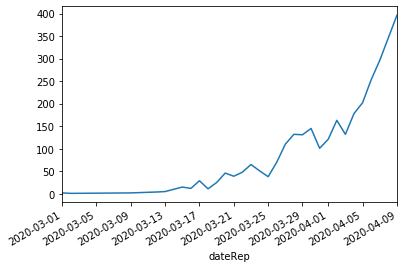

In [14]:
# Mexico Database
shortMex=data_who[data_who.countriesAndTerritories=='Mexico']['cases'].loc['2020-03-01':'2020-04-09']
shortMex.plot()
data_mex=pd.DataFrame(shortMex)
data_mex.rename(columns={'cases':0},inplace=True)


In [15]:
data_mex.columns

Int64Index([0], dtype='int64')

In [16]:
ncol=[casess_cdmx[0]]
for i in range(1,casess_cdmx.shape[0]):
    ncol.append(casess_cdmx[i]+ncol[i-1])
casess_cdmx['prevalence']=ncol

data_cdmx=pd.DataFrame(casess_cdmx['prevalence'])
#data_cdmx.rename(columns={'prevalence':0}) not necessary

In [17]:
#index datetime range
quasiAlldata=[data_usa,data_slov,data_iran,data_ger,data_mex,data_cdmx]

startDate=['2020-02-24','2020-03-01','2020-02-18','2020-02-23','2020-03-01','2020-02-26']
for data,i in zip(quasiAlldata,range(len(quasiAlldata))):
    data['datetime']=pd.date_range(start=startDate[i],periods=len(data),freq='D')
    data.set_index('datetime',inplace=True)


In [18]:
#data_mex.head

In [19]:
allData=[data_usa,data_slov,data_iran,data_ger,data_mex,data_cdmx]
allData_labels=['USA','SLOVENIA','IRAN','GERMANY','MEXICO','CDMX']
allData_dict=dict()

for i in range(len(allData)):
    allData_dict[allData_labels[i]]=allData[i]

In [20]:
def cfrate(positive_cases,deaths_positive):
    cfr=sum(deaths_cases)/sum(cases_positive)
    return(cfr)
    

// determine minimal, maximal, and average growth rate during the past lastxdays (14 default, but check data to adjust

In [21]:
daystoheal=int(14);
daystodie=int(21);
deathrate=0.04


In [22]:
# Calculate the avr growth rate

def growrate_healed_died(data,daystodie,daystoheal,deathrate):
    growrate=np.zeros(len(data))
    healed=np.zeros(len(data))
    died=np.zeros(len(data))
    for i in range(1,len(data)):
        growrate[i]=(data.iloc[i]/(data.iloc[i-1]))-1
        healed[i]=data.iloc[i-daystoheal]*(1-deathrate)
        died[i]=data.iloc[i-daystodie]*deathrate
    return(growrate,healed,died)


In [23]:
#grow_h_d=growrate_healed_died(data,daystodie,daystoheal,deathrate)
#len(grow_h_d[0])

In [24]:
# Compute avgrowthrate, min and max
lastxdays=14
#lastxdays=len(data)-daystodie
mingrowrate=1e9
maxgrowrate=0.0
avggrowrate=0.0 

def min_max_avg(data,growrateVector,mingrowrate,maxgrowrate,avggrowrate,lastxdays):
    growrate=growrateVector
    for i in range(len(data)-lastxdays,len(data)):
        avggrowrate=avggrowrate+growrate[i]
        if (growrate[i]<mingrowrate): mingrowrate=growrate[i]
        if (growrate[i]>maxgrowrate): maxgrowrate=growrate[i]
    avggrowrate=avggrowrate/lastxdays
    return(mingrowrate,maxgrowrate,avggrowrate)



In [25]:
grow_h_d=growrate_healed_died(data_mex,daystodie,daystoheal,deathrate)
growrateVec_mex=grow_h_d[0]
#avvg_mex=min_max_avg(data_mex,growrateVec_mex,mingrowrate,maxgrowrate,avggrowrate,lastxdays)
avg_mex=min_max_avg(data_mex,growrateVec_mex,mingrowrate,maxgrowrate,0,lastxdays)
avg_mex

(-0.303448275862069, 0.5714285714285714, 0.1529569698818971)

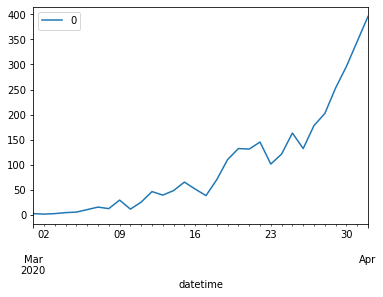

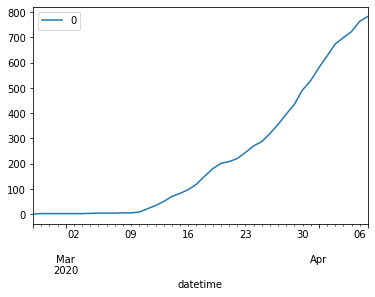

In [26]:
data_mex.plot()
data_cdmx.plot()

In [27]:
grow_h_d_cdmx=growrate_healed_died(data_cdmx,daystodie,daystoheal,deathrate)
growrateVec_cdmx=grow_h_d_cdmx[0]
#avvg_mex=min_max_avg(data_mex,growrateVec_mex,mingrowrate,maxgrowrate,avggrowrate,lastxdays)
avg_cdmx=min_max_avg(data_cdmx,growrateVec_cdmx,mingrowrate,maxgrowrate,0,lastxdays)
avg_cdmx

(0.024869109947643908, 0.13103448275862073, 0.07949495911236551)

In [28]:
avggrowrate

0.0

In [29]:
#growrates=min_max_avg(data,grow_h_d[0],mingrowrate,maxgrowrate,avggrowrate,lastxdays)
#mingrowrate=growrates[0]
#maxgrowrate=growrates[1]
#avggrowrate=growrates[2]

In [30]:
#Forecasting

#healed, died passed
maxgrowrate=maxgrowrate*1.2
decgrowrate=maxgrowrate/30.0
def forecasting(data,mingrowrate,maxgrowrate,avggrowrate,decgrowrate,daystoheal,daystodie):
    mat=np.zeros((daystoheal,30))
    mat2=np.zeros((daystoheal,30))
    for q in range(30):
        predict=data.iloc[len(data)-1]
        for i in range(len(data),len(data)+daystoheal):
            predict=predict*(1+maxgrowrate-q*decgrowrate)
            healed=0.0;died=0.0;
            if ((i-daystoheal)>=0): healed=data.iloc[i-daystoheal]*(1-deathrate)
            if ((i-daystodie)>=0): died=data.iloc[i-daystodie]*deathrate
            mat[i-len(data),q]=predict-healed-died
            mat2[i-len(data),q]=maxgrowrate-q*decgrowrate
    #df=pd.DataFrame(mat,index=range(len(data),len(data)+daystoheal))
    df=pd.DataFrame(mat)
    return(mat,df)


In [35]:
#healed=grow_h_d[1]
#died=grow_h_d[2]
maxgrowrate


0.0

In [32]:
mat_pred=forecasting(data_mex,mingrowrate,maxgrowrate,avggrowrate,decgrowrate,daystoheal,daystodie)

In [33]:
mat=mat_pred[0]
pred=mat_pred[1]

In [40]:
#pred.plot()

In [41]:
def data_predict(data,pred):
    data_pred=pd.concat([data, pred], ignore_index=True)
    #data_pred['datetime']=pd.date_range(start='02/23/2020',periods=len(data_pred),freq='D')
    data_pred['datetime']=pd.date_range(start=data.index[0],periods=len(data_pred),freq='D')
    data_pred.set_index('datetime',inplace=True)
    return(data_pred)

In [42]:
#data_pred=data_predict(data_mex,pred)

In [43]:
#data_pred

In [76]:
colors=['r','b','g']

def plots(data_pred,title,string):
    fig,ax1=plt.subplots()
    #data_pred[0][:len(data)].plot(legend=False,ax=ax1,color='k')
    data_pred[0].plot(legend=False,ax=ax1,color='k')
    for i in range(1,15):
        data_pred[i].plot(legend=False,ax=ax1,color=colors[0])
    for i in range(15,30):
        data_pred[i].plot(legend=False,ax=ax1,color=colors[1])
    data_pred[29].plot(legend=False,ax=ax1,color='g')
    ax1.set_title(title)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of cases')
    ax1.grid()
    plt.yscale('log')
    save_fig(fig,title+string)
    plt.show()

In [77]:
#Function for diferent daystodie values
daystodieVector=range(17,21)

def plot_data(data,daystodie,daystoheal,deathrate,title,string):
    grow_h_d=growrate_healed_died(data,daystodie,daystoheal,deathrate)
    
    
    # Compute avgrowthrate, min and max
    lastxdays=14
    #lastxdays=len(data)-daystodie
    mingrowrate=1e9
    maxgrowrate=0.0
    avggrowrate=0.0 

    growrates=min_max_avg(data,grow_h_d[0],mingrowrate,maxgrowrate,avggrowrate,lastxdays)
    mingrowrate=growrates[0]
    maxgrowrate=growrates[1]
    avggrowrate=growrates[2]

    #healed, died passed
    #maxgrowrate=maxgrowrate*1.2
    maxgrowrate=maxgrowrate*(1+avggrowrate)
    decgrowrate=maxgrowrate/30.0

    mat_pred=forecasting(data,mingrowrate,maxgrowrate,avggrowrate,decgrowrate,daystoheal,daystodie)

    mat=mat_pred[0]
    pred=mat_pred[1]

    data_pred=data_predict(data,pred)

    plots(data_pred,title,string)
    return(data_pred,mingrowrate,maxgrowrate,avggrowrate)




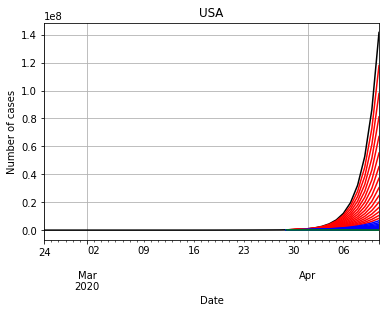

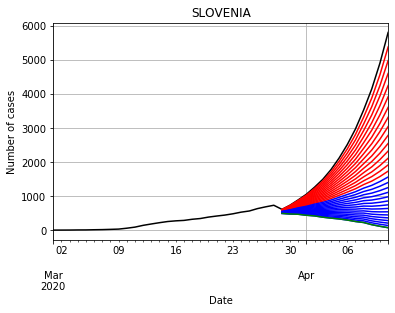

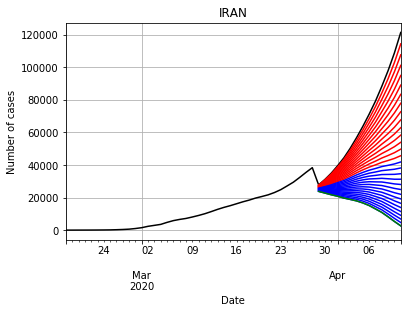

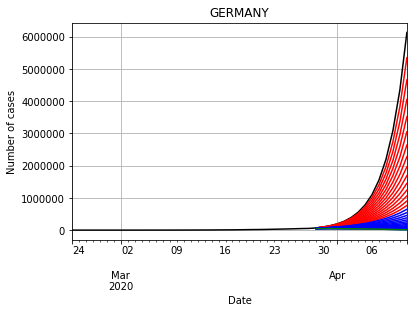

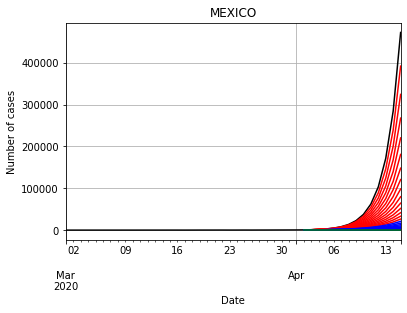

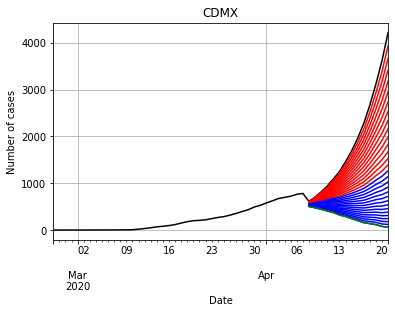

In [65]:
pred_dict=dict()
for key in allData_dict.keys():
    pred_dict[key]=plot_data(allData_dict[key],daystodie,daystoheal,deathrate,key,'_daystodie_'+str(daystodie))[0]
    #print("using last %ld days\n",lastxdays);
    #mingr=avg_dict[key][1]
    #maxgr=avg_dict[key][2]
    #avggr=avg_dict[key][3]
    #print("maximal growth rate is %.4lf\n",maxgr);
    #print("average growth rate is %.4lf\n",avggr);
#print(pre_dict)

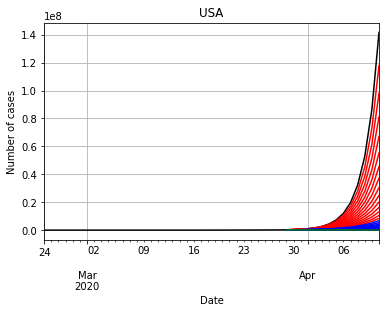

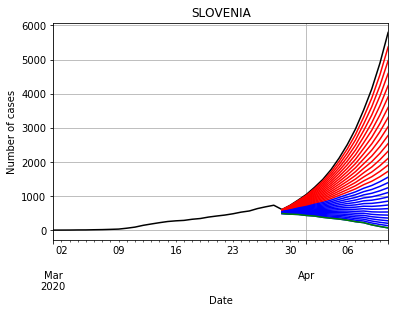

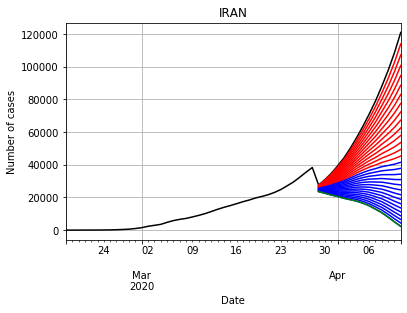

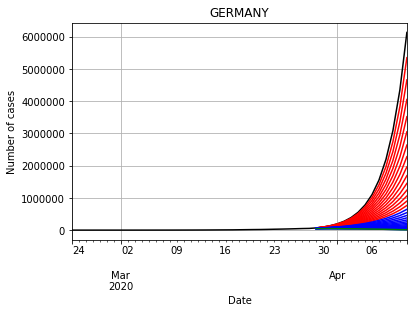

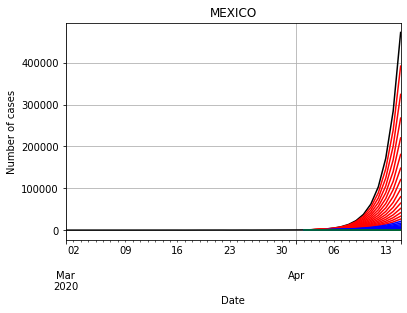

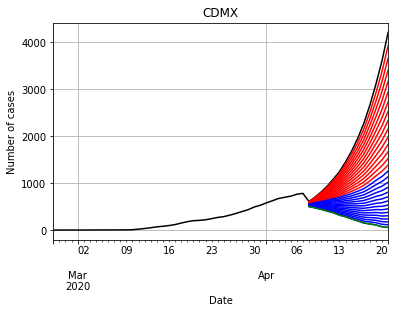

In [66]:
pred_dict1=dict()
for key in allData_dict.keys():
    pred_dict1[key]=plot_data(allData_dict[key],17,daystoheal,deathrate,key,'_daystodie_'+str(17))[0]
    #print("using last %ld days\n",lastxdays);
    #mingr=avg_dict[key][1]
    #maxgr=avg_dict[key][2]
    #avggr=avg_dict[key][3]
    #print("maximal growth rate is %.4lf\n",maxgr);
    #print("average growth rate is %.4lf\n",avggr);
#print(pre_dict)

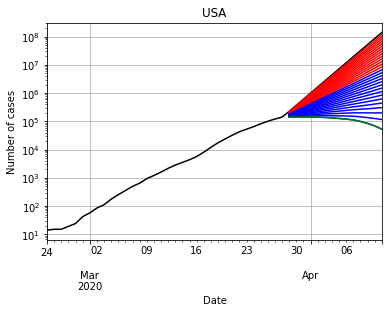

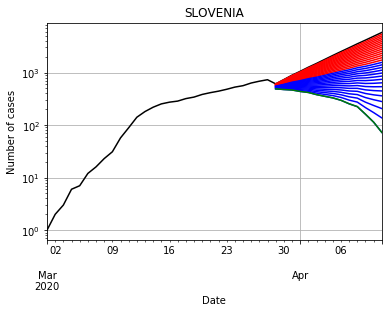

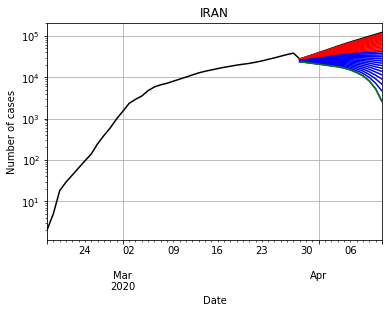

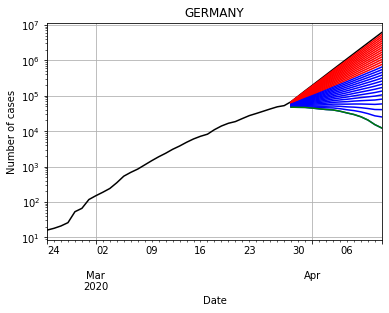

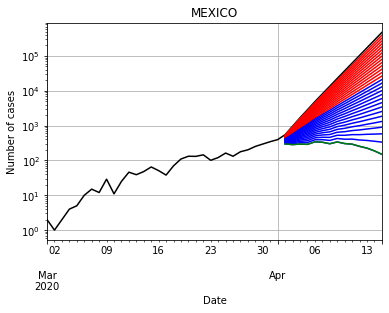

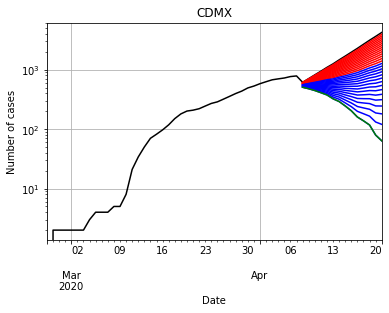

{'USA': (0.1700672969737005, 0.6379359126749575, 0.30595703827018417), 'SLOVENIA': (0.04761904761904767, 0.16925106352356387, 0.09017596799001368), 'IRAN': (0.04917532070861341, 0.10696576111027356, 0.07499493206039147), 'GERMANY': (0.08161458976575697, 0.4057108318338685, 0.18743927146521022), 'MEXICO': (-0.303448275862069, 0.6588325542182268, 0.1529569698818971), 'CDMX': (0.024869109947643908, 0.14145106360782725, 0.07949495911236551)}


In [78]:
avg_dict=dict()
for key in allData_dict.keys():
    avg_dict[key]=plot_data(allData_dict[key],daystodie,daystoheal,deathrate,key,'_daystodie_'+str(daystodie))[1:]
    #print("using last %ld days\n",lastxdays);
    #mingr=avg_dict[key][1]
    #maxgr=avg_dict[key][2]
    #avggr=avg_dict[key][3]
    #print("maximal growth rate is %.4lf\n",maxgr);
    #print("average growth rate is %.4lf\n",avggr);
print(avg_dict)


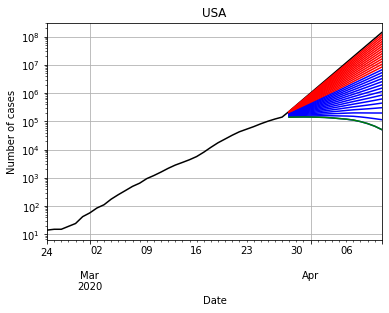

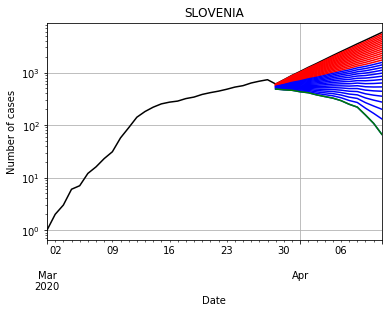

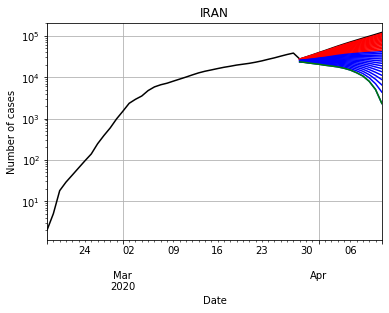

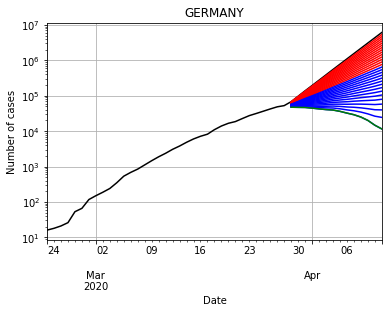

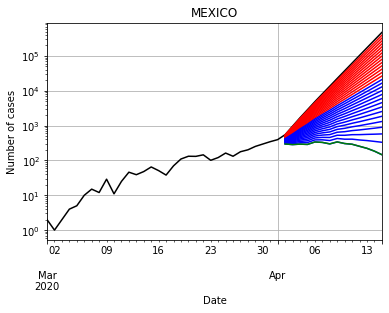

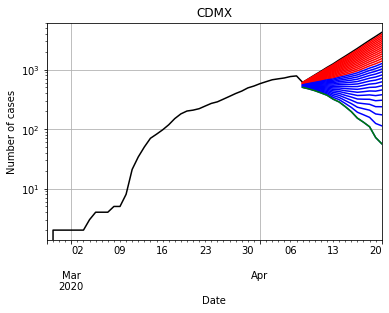

In [79]:
avg_dict1=dict()
for key in allData_dict.keys():
    avg_dict1[key]=plot_data(allData_dict[key],17,daystoheal,deathrate,key,'_daystodie_'+str(17))[1:]
    #print("using last %ld days\n",lastxdays);
    #mingr=avg_dict[key][1]
    #maxgr=avg_dict[key][2]
    #avggr=avg_dict[key][3]
    #print("maximal growth rate is %.4lf\n",maxgr);
    #print("average growth rate is %.4lf\n",avggr);
#print(avg_dict1)


In [72]:
pred_dict['MEXICO'].shape

(46, 30)

In [73]:
pred_dict1['MEXICO'].shape

(46, 30)

In [75]:
pred_dict['MEXICO']==pred_dict1['MEXICO']

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-01,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-03-02,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-03-03,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-03-04,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-03-05,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-03-06,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-03-07,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-03-08,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-03-09,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
